![AIcrowd-Logo](https://images.aicrowd.com/raw_images/challenges/banner_file/677/b1c94f799d0062e9b50b.jpg)


## Starter Kit for [Sound Sentiment Prediction Puzzle](https://www.aicrowd.com/blitz/puzzles/sound-sentiment-prediction)

## Let's import necessary packages!

In [2]:
# !pip install --upgrade fastai
# !pip install librosa

In [3]:
import sys
import zipfile
import librosa
import pandas as pd
import cv2
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
from fastai.vision.all import *
import fastai
import os
import matplotlib.pyplot as plt
from IPython.display import Audio

In [4]:
zip_data = False

if zip_data:
    zip_path = r"C:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\PW-Deep\SoundSentimentClassification\Dataset"

    with zipfile.ZipFile(zip_path + "\\train.zip", 'r') as zip_ref:
        zip_ref.extractall(zip_path + "\\train") 

## Load Data

In [5]:
dataset_path = r"C:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\PW-Deep\SoundSentimentClassification\Dataset"
train_df = pd.read_csv(dataset_path + "\\train.csv")
val_df = pd.read_csv(dataset_path + "\\val.csv")

print("Shape of train_df: ", train_df.shape)
print("Shape of val_df: ", val_df.shape)

train_df.head() 

Shape of train_df:  (15000, 2)
Shape of val_df:  (2000, 2)


,label,wav_id
0,2,0
1,2,1
2,2,2
3,2,3
4,2,4


## Exploratory Dataset Analysis

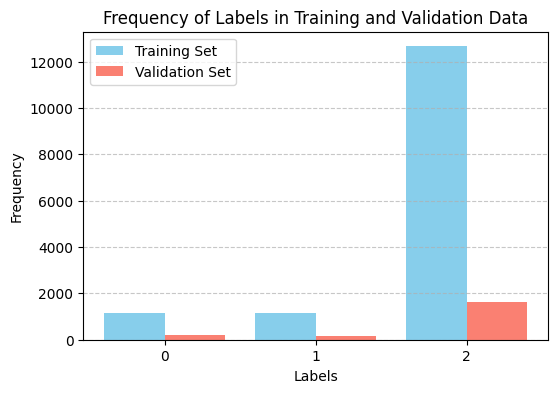

In [6]:
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()

# Ensure both datasets have the same index for alignment
all_labels = sorted(set(train_counts.index).union(set(val_counts.index)))
train_counts = train_counts.reindex(all_labels, fill_value=0)
val_counts = val_counts.reindex(all_labels, fill_value=0)
# Define bar width and positions
bar_width = 0.4
x = np.arange(len(all_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width / 2, train_counts, width=bar_width, color='skyblue', label='Training Set')
plt.bar(x + bar_width / 2, val_counts, width=bar_width, color='salmon', label='Validation Set')

plt.title('Frequency of Labels in Training and Validation Data')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(x, all_labels)  # Set x-axis labels to the actual labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Label for the audio:  2


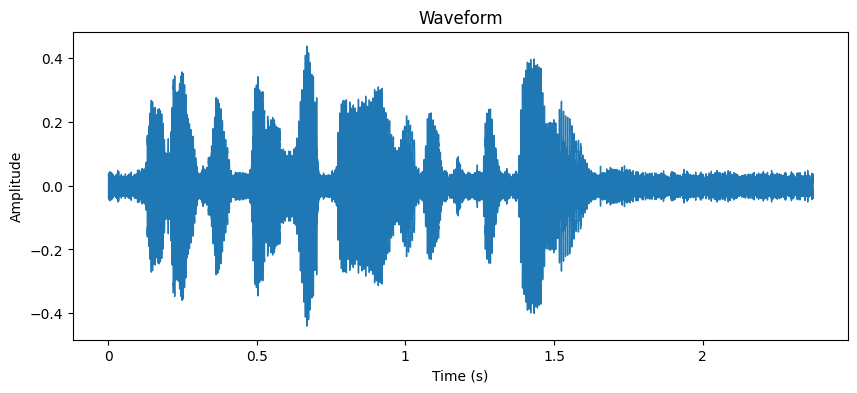

In [ ]:
# Change the n parameter to analuyze different audio samples
n = 0

audio_path = dataset_path + f"\\train\\{n}.wav"

print("Label for the audio: ", train_df.loc[n, 'label'])

y, sr = librosa.load(audio_path, sr=None)  # y is the audio signal, sr is the sample rate
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)  # Compute the STFT and convert to dB
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

Audio(audio_path)

In [54]:
wav_files_path_train = dataset_path + "\\train"

features = []

# Iterate through all .wav files in the directory
for file_name in os.listdir(wav_files_path_train):
    if file_name.endswith(".wav"):
        file_path = os.path.join(wav_files_path_train, file_name)
        try:
            # Load the audio file with Librosa library
            y, sr = librosa.load(file_path, sr=None)  # Load with original sample rate
            # Calculate features
            duration = librosa.get_duration(y=y, sr=sr)
            rmse = np.mean(librosa.feature.rms(y=y))  # Root Mean Square Energy
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))  # Zero Crossing Rate
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)  # First 13 MFCCs
            # Append to features list
            features.append({
                "file_name": file_name,
                "duration": duration,
                "rmse": rmse,
                "zcr": zcr,
                "spectral_centroid": spectral_centroid,
                "spectral_bandwidth": spectral_bandwidth,
                **{f"mfcc_{i+1}": mfcc for i, mfcc in enumerate(mfccs)}
            })          
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

# Convert features to a DataFrame for easier analysis
features_df = pd.DataFrame(features)
# Save the features to a CSV for further analysis
features_df.to_csv("audio_features.csv", index=False)
# Print a preview
print(features_df.columns)

Index(['file_name', 'duration', 'rmse', 'zcr', 'spectral_centroid',
       'spectral_bandwidth', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5',
       'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
       'mfcc_13'],
      dtype='object')


Mean Duration: 2.54 seconds
Min Duration: 1.32 seconds
Max Duration: 6.53 seconds


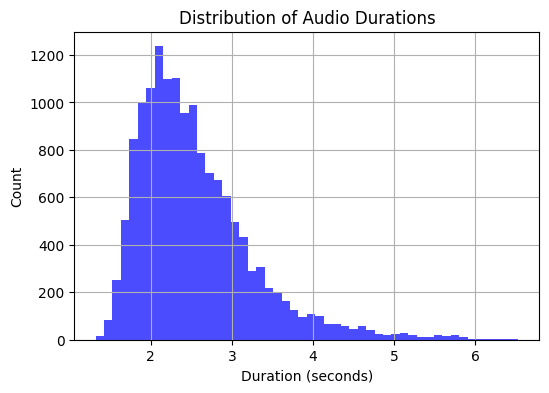

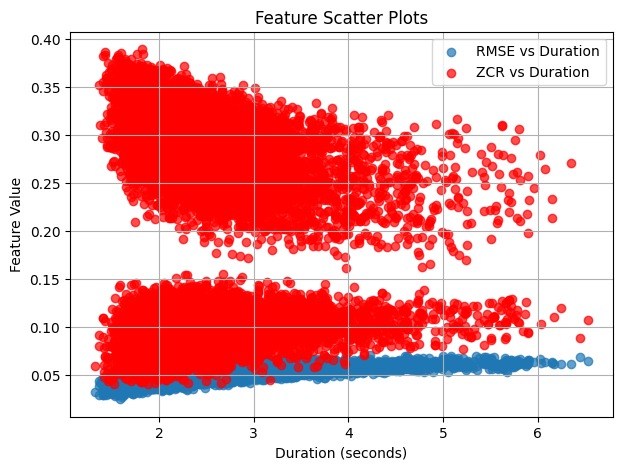

In [55]:
# Basic statistics
mean_duration = np.mean(features_df['duration'])
min_duration = np.min(features_df['duration'])
max_duration = np.max(features_df['duration'])
print(f"Mean Duration: {mean_duration:.2f} seconds")
print(f"Min Duration: {min_duration:.2f} seconds")
print(f"Max Duration: {max_duration:.2f} seconds")

# Plot the histogram of durations
plt.figure(figsize=(6, 4))
plt.hist(features_df['duration'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Plot some features
plt.figure(figsize=(7, 5))
plt.scatter(features_df["duration"], features_df["rmse"], alpha=0.7, label="RMSE vs Duration")
plt.scatter(features_df["duration"], features_df["zcr"], alpha=0.7, label="ZCR vs Duration", color="red")
plt.title("Feature Scatter Plots")
plt.xlabel("Duration (seconds)")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.show()

The ZCR clustering could indicate two distinct types of audio signals in the dataset --> 2 groups of files, one with more noise and the other clearer

The energy (RMSE) is stable across all durations --> all files have the same loudness

## Preprocessing Data

#### 1' approach: Convert audio signal into images
Train a Convolutional neural network with them

Workflow to covert spectogram to images:
1. Load an audio file.

2. Compute its mel-spectrogram.

3. Convert the spectrogram to decibel scale for better visualization.

4. Normalize and scale it into an image-like format.

5. Save the spectrogram as a .jpg file.

In [74]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    """
    Convert a 1-channel image to a 3-channel image

    Arguments:
        X: the input image as a numpy array (matrix) -> spectogram
        mean: (optional) the mean value of the input image. If None, calculate from X
        std: (optional) the standard deviation of the input image. If None, calculate from X
        norm_max: (optional) the maximum value of the output image. If None, calculate from X
        norm_min: (optional) the minimum value of the output image. If None, calculate from X
        eps: a small number to prevent dividing by zero
    Returns:
        A 3-channel image as a numpy array
    """
    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)

    # Min-Max normalization
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    # Normalize to [0, 255]
    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    # uint8 matrix scaled to the range [0, 255]., as an 8-bit grayscale image.
    return V 

In [79]:
training_sound_paths = os.listdir(dataset_path + "\\train")
spec_imgs_path = dataset_path + "\\train\\spec_imgs"

if not os.path.exists(spec_imgs_path):
    os.mkdir(spec_imgs_path)
else:
    if len(os.listdir(spec_imgs_path)) < 15000:
        print("Inizio conversione in immagini")
        for n, sound_path in enumerate(training_sound_paths):
            sound_file_path = dataset_path + f"\\train\\{sound_path}"
            # Load audio into a waveform (y) and sampling rate (sr)
            y, sr = librosa.load(sound_file_path)
            total_secs = y.shape[0] / sr
            # Convert the waveform to a mel-spectogram (mel scale: mel scale approximates human auditory perception)
            M = librosa.feature.melspectrogram(y=y, sr=sr)
            # Converts the mel-spectrogram's power values to db scale, making it more visually interpretable.
            M = librosa.power_to_db(M)
            # Transform the mel-spectogram into an image
            M = mono_to_color(M)

            cv2.imwrite(f"{spec_imgs_path}\\{n}.jpg", M, [int(cv2.IMWRITE_JPEG_QUALITY), 85]) # [int(cv2.IMWRITE_JPEG_QUALITY), 85]: Sets the JPEG quality to 85 for compression while retaining good quality
    else:
        print("Conversion in immagini già effettuata")

Conversion in immagini già effettuata


In [1]:
# Creazione del nome dei file immagini
train_df['name'] = "spec_imgs\\" + train_df['wav_id'].astype(str) + ".jpg"
train_df.label = train_df.label.astype(str)
train_df.head()

NameError: name 'train_df' is not defined

Data preparation: Load the dataset, Apply trasformations, Batching

In [86]:
train_path = r"C:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\PW-Deep\SoundSentimentClassification\Dataset\train"

dls = ImageDataLoaders.from_df(train_df, 
                               path=train_path, 
                               label_col=0, 
                               fn_col=2, 
                               item_tfms=Resize(224), 
                               bs=6, 
                               num_workers=0)

c:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\PW-Deep\SoundSentimentClassification\.venv\lib\site-packages\fastai\data\transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


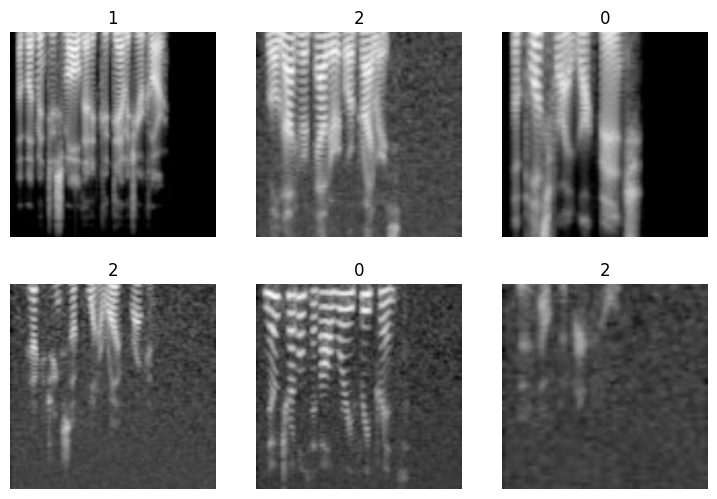

In [87]:
dls.show_batch()

## Train the CNN model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.016618,1.297288,0.600000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.175006,1.365746,0.400000,00:01


In [ ]:
# learn = vision_learner(dls, resnet34, metrics=accuracy)
# learn.fine_tune(1)

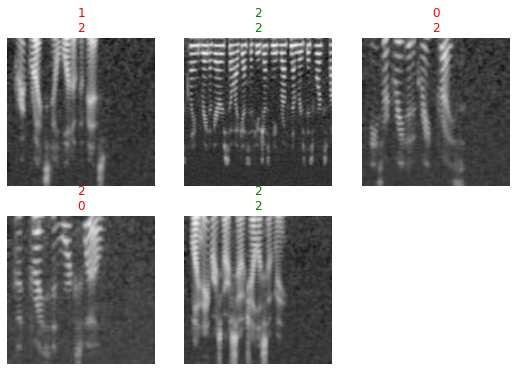

In [ ]:
learn.show_results()

## Generating predictions

In [ ]:
os.makedirs("test_spec_imgs", exist_ok=True)

test_sound_paths = os.listdir("test")

test_img_paths = []
for n, sound_path in enumerate(test_sound_paths):
    y, sr = librosa.load(f"test/{sound_path}")
    total_secs = y.shape[0] / sr
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M = librosa.power_to_db(M)
    M = mono_to_color(M)

    cv2.imwrite(f"./test_spec_imgs/{n}.jpg", M, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
    test_img_paths.append(f"./test_spec_imgs/{n}.jpg")

In [ ]:
test_predictions = []

for test_img_path in test_img_paths:
  prediction = learn.predict(test_img_path)
  test_predictions.append(int(prediction[0][0]))

Output hidden; open in https://colab.research.google.com to view.

## Let's make the final file with the results

In [ ]:
test_img_paths = [int(i.split(".")[-2].split("/")[-1]) for i in test_img_paths]
submission = pd.DataFrame({"wav_id":test_img_paths, "label":test_predictions})
submission

In [ ]:
submission.to_csv("submission.csv", index=False)

## 2' approach: extract the text from the sound signal and perform a sentiment analysis on them

## 3' approeach: combine the First and Second approaches